In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 41kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os

# Location of Zip File
drive_path = '/content/drive/My Drive/Colab Notebooks/catnocat/data.zip'
local_path = '/content/catnocat'
os.mkdir(local_path)


In [9]:
# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' '{local_path}'

In [10]:
# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'data.zip'

In [11]:
!nvidia-smi

Sat Apr  3 10:52:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import MobileNet
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
import itertools
import matplotlib.image as mpimg

In [13]:
tf.__version__

'2.4.1'

In [14]:
data_path = '/content/catnocat'

train_data_path = os.path.join(data_path, 'train')
valid_data_path = os.path.join(data_path, 'valid')
# holytest_data_path = os.path.join(data_path, 'holytest')

print("Path to training set: ", train_data_path)
print("Path to validation set: ", valid_data_path)

Path to training set:  /content/catnocat/train
Path to validation set:  /content/catnocat/valid


In [15]:
image_size = (224, 224)
batch_size = 32

In [16]:
# Set Data Generator for training, testing and validation.

# Note for testing, set shuffle = false (For proper Confusion matrix)
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_dataset = train_datagen.flow_from_directory(train_data_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
valid_dataset = valid_datagen.flow_from_directory(valid_data_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

# test_datagen = ImageDataGenerator(rescale=1/255)
# test_dataset = test_datagen.flow_from_directory(holytest_data_path,
#                                                 target_size=image_size,
#                                                 batch_size=batch_size,
#                                                 class_mode='categorical',
#                                                 shuffle=False)


Found 9402 images belonging to 2 classes.
Found 3133 images belonging to 2 classes.


In [17]:
# # Lets now use MobileNet as it is quite lightweight (17Mb), freeze the base layers and lets add and train the top
# # few layers. Note only two classifiers.

base_model = MobileNet(weights='imagenet',
                       include_top=False)  # imports the mobilenet model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(
    x)  # we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(1024, activation='relu')(x)  # dense layer 2
x = Dense(512, activation='relu')(x)  # dense layer 3
preds = Dense(2, activation='softmax')(x)  # final layer with softmax activation

model = Model(inputs=base_model.input, outputs=preds)
# specify the inputs
# specify the outputs
# now a model has been created based on our architecture

17227776/17225924 [==============================] - 0s 0us/step


In [18]:
# check the architecture
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1
2 conv1_bn
3 conv1_relu
4 conv_dw_1
5 conv_dw_1_bn
6 conv_dw_1_relu
7 conv_pw_1
8 conv_pw_1_bn
9 conv_pw_1_relu
10 conv_pad_2
11 conv_dw_2
12 conv_dw_2_bn
13 conv_dw_2_relu
14 conv_pw_2
15 conv_pw_2_bn
16 conv_pw_2_relu
17 conv_dw_3
18 conv_dw_3_bn
19 conv_dw_3_relu
20 conv_pw_3
21 conv_pw_3_bn
22 conv_pw_3_relu
23 conv_pad_4
24 conv_dw_4
25 conv_dw_4_bn
26 conv_dw_4_relu
27 conv_pw_4
28 conv_pw_4_bn
29 conv_pw_4_relu
30 conv_dw_5
31 conv_dw_5_bn
32 conv_dw_5_relu
33 conv_pw_5
34 conv_pw_5_bn
35 conv_pw_5_relu
36 conv_pad_6
37 conv_dw_6
38 conv_dw_6_bn
39 conv_dw_6_relu
40 conv_pw_6
41 conv_pw_6_bn
42 conv_pw_6_relu
43 conv_dw_7
44 conv_dw_7_bn
45 conv_dw_7_relu
46 conv_pw_7
47 conv_pw_7_bn
48 conv_pw_7_relu
49 conv_dw_8
50 conv_dw_8_bn
51 conv_dw_8_relu
52 conv_pw_8
53 conv_pw_8_bn
54 conv_pw_8_relu
55 conv_dw_9
56 conv_dw_9_bn
57 conv_dw_9_relu
58 conv_pw_9
59 conv_pw_9_bn
60 conv_pw_9_relu
61 conv_dw_10
62 conv_dw_10_bn
63 conv_dw_10_relu
64 conv_pw_10
65 conv_pw_1

In [19]:
# We will use pre-trained weights as the model has been trained already on the Imagenet dataset. We ensure all the
# weights are non-trainable. We will only train the last few dense layers.

for layer in model.layers:
    layer.trainable = False
# or if we want to set the first n layers of the network to be non-trainable
n = 79
for layer in model.layers[:n]:
    layer.trainable = False
for layer in model.layers[n:]:
    layer.trainable = True

In [20]:
# Compile and train the model.

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

In [22]:
epochs = 5
step_size_train = train_dataset.n // train_dataset.batch_size
history = model.fit(train_dataset,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=valid_dataset,
                    )

Epoch 1/5
293/293 [==============================] - 59s 201ms/step - loss: 0.0698 - accuracy: 0.9779 - val_loss: 0.2325 - val_accuracy: 0.9496
Epoch 2/5
293/293 [==============================] - 59s 201ms/step - loss: 0.0474 - accuracy: 0.9853 - val_loss: 0.1178 - val_accuracy: 0.9713
Epoch 3/5
293/293 [==============================] - 59s 200ms/step - loss: 0.0443 - accuracy: 0.9867 - val_loss: 0.1035 - val_accuracy: 0.9684
Epoch 4/5
293/293 [==============================] - 59s 200ms/step - loss: 0.0350 - accuracy: 0.9895 - val_loss: 0.0550 - val_accuracy: 0.9856
Epoch 5/5
293/293 [==============================] - 58s 199ms/step - loss: 0.0333 - accuracy: 0.9899 - val_loss: 0.0698 - val_accuracy: 0.9840


In [23]:
# Save the model
model.save("cats_mobilenet.hdf5")

In [24]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# PREDICTION
Y_pred = model.predict_generator(valid_dataset, step_size_train + 1)
y_pred = np.argmax(Y_pred, axis=1)

['cat', 'nocat']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [106]:
# Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(valid_dataset.classes, y_pred))
print('Classification Report')
class_names = list(valid_dataset.class_indices.keys())
print(classification_report(valid_dataset.classes, y_pred, target_names=class_names))


Confusion Matrix
[[ 915   34]
 [  16 2168]]
Classification Report
              precision    recall  f1-score   support

         cat       0.98      0.96      0.97       949
       nocat       0.98      0.99      0.99      2184

    accuracy                           0.98      3133
   macro avg       0.98      0.98      0.98      3133
weighted avg       0.98      0.98      0.98      3133



In [107]:
# Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [109]:
# Confusion Matrix
print('Confusion Matrix')
cm = confusion_matrix(valid_dataset.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# Print Classification Report

print('Classification Report')
print(classification_report(valid_dataset.classes, y_pred, target_names=class_names))

Confusion Matrix
Normalized confusion matrix


Classification Report
              precision    recall  f1-score   support

         cat       0.98      0.96      0.97       949
       nocat       0.98      0.99      0.99      2184

    accuracy                           0.98      3133
   macro avg       0.98      0.98      0.98      3133
weighted avg       0.98      0.98      0.98      3133



In [30]:
# PREDICTIONS 2
ground_truth = valid_dataset.classes
print(ground_truth[:10])
print(len(ground_truth))

[0 0 0 0 0 0 0 0 0 0]
3133


In [31]:
# Then we get the predictions. This will be a list of probability values that express how confident
# the model is about the presence of each category in each image. This step might take several minutes.

predictions = model.predict_generator(valid_dataset,
                                      steps=None)
print(predictions[:10])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[9.99893665e-01 1.06269756e-04]
 [9.99999881e-01 8.04821880e-08]
 [1.00000000e+00 3.71850373e-09]
 [1.00000000e+00 9.08905937e-11]
 [1.00000000e+00 5.48574809e-20]
 [9.99910712e-01 8.92730241e-05]
 [1.00000000e+00 1.94418816e-15]
 [9.86664653e-01 1.33353723e-02]
 [9.73518670e-01 2.64812950e-02]
 [1.00000000e+00 2.96486018e-08]]


In [110]:
prediction_table = {}
for index, val in enumerate(predictions):
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [
        value_of_highest_probability,
        index_of_highest_probability,
        ground_truth[index]
    ]
assert len(predictions) == len(ground_truth) == len(prediction_table)


In [111]:
def reverse_dict(class_dict):
  reversed = {}
  for key, value in class_dict.items():
    reversed[value] = key
  return reversed

def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]


def plot_images(filenames, distances, classification_txt, title_txt):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 24))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + 
                     "\n" + classification_txt + 
                     "\nprobability=" + str(float("{0:.2f}".format(distances[i])))
                     )
        plt.suptitle(title_txt, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
    plt.show()


filenames = valid_dataset.filenames
class_dict = reverse_dict(valid_dataset.class_indices)

def display(sorted_indices, title_txt):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        if predicted_index == gt:
            classification_txt = "CORRECT"
        else:
            classification_txt = "WRONG"
        classification_txt = "{}\nground truth: {}\npredicted: {}".format(classification_txt, 
                                                                 class_dict[gt].upper(), 
                                                                 class_dict[predicted_index].upper())
        similar_image_paths.append(os.path.join(valid_data_path, filenames[name]))
        distances.append(probability)
    plot_images(similar_image_paths, distances, classification_txt, title_txt)


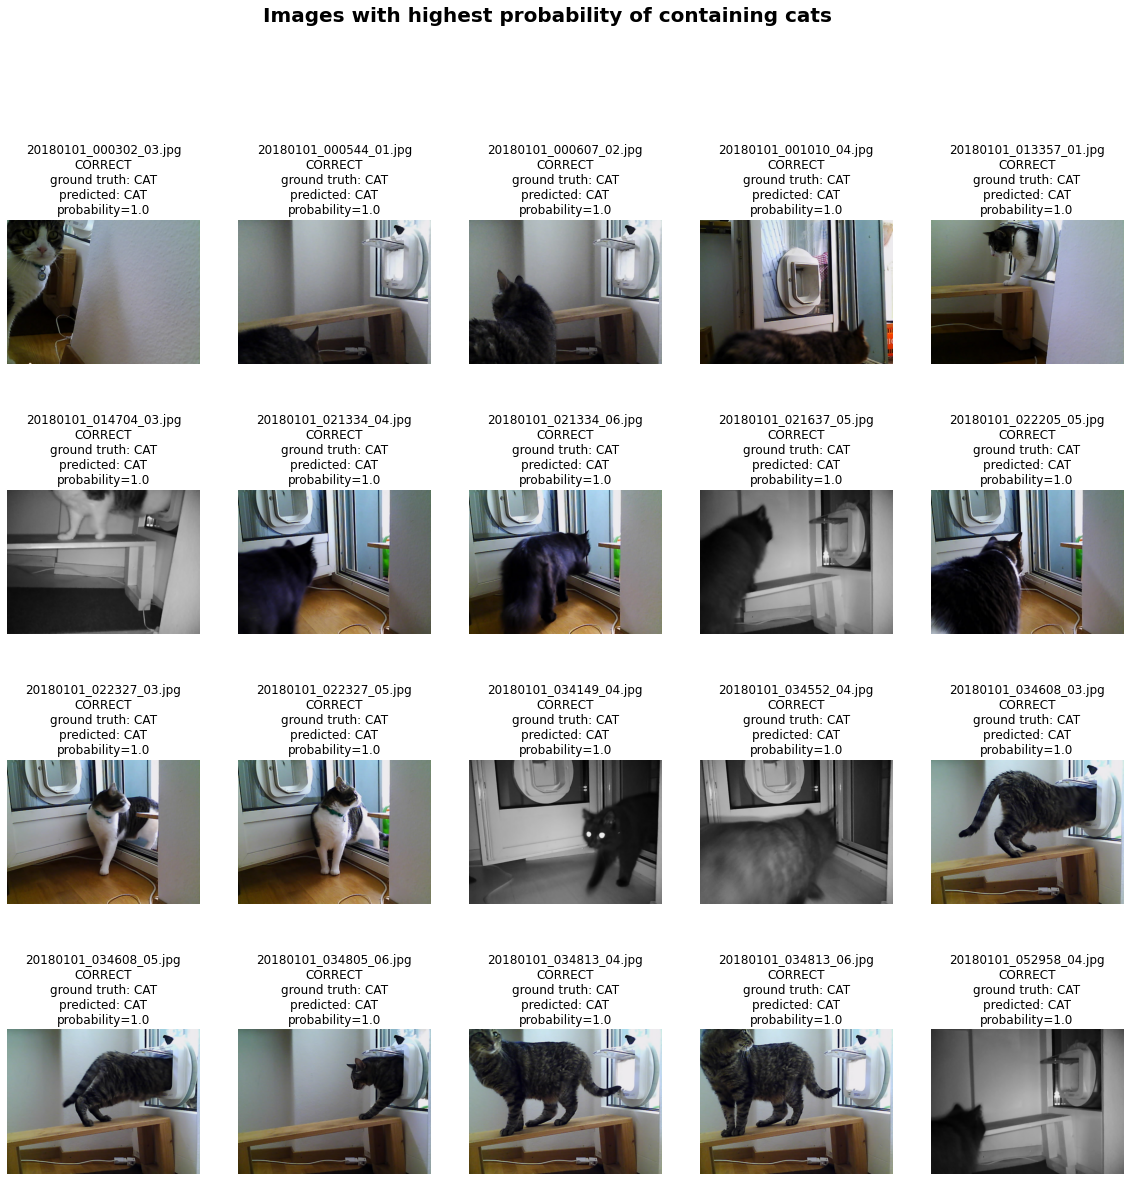

In [112]:
img_list = get_images_with_sorted_probabilities(prediction_table,
                                                             get_highest_probability=True,
                                                             label=0,
                                                             number_of_items=20,
                                                             only_false_predictions=False)
message = 'Images with highest probability of containing cats'
display(img_list, message)

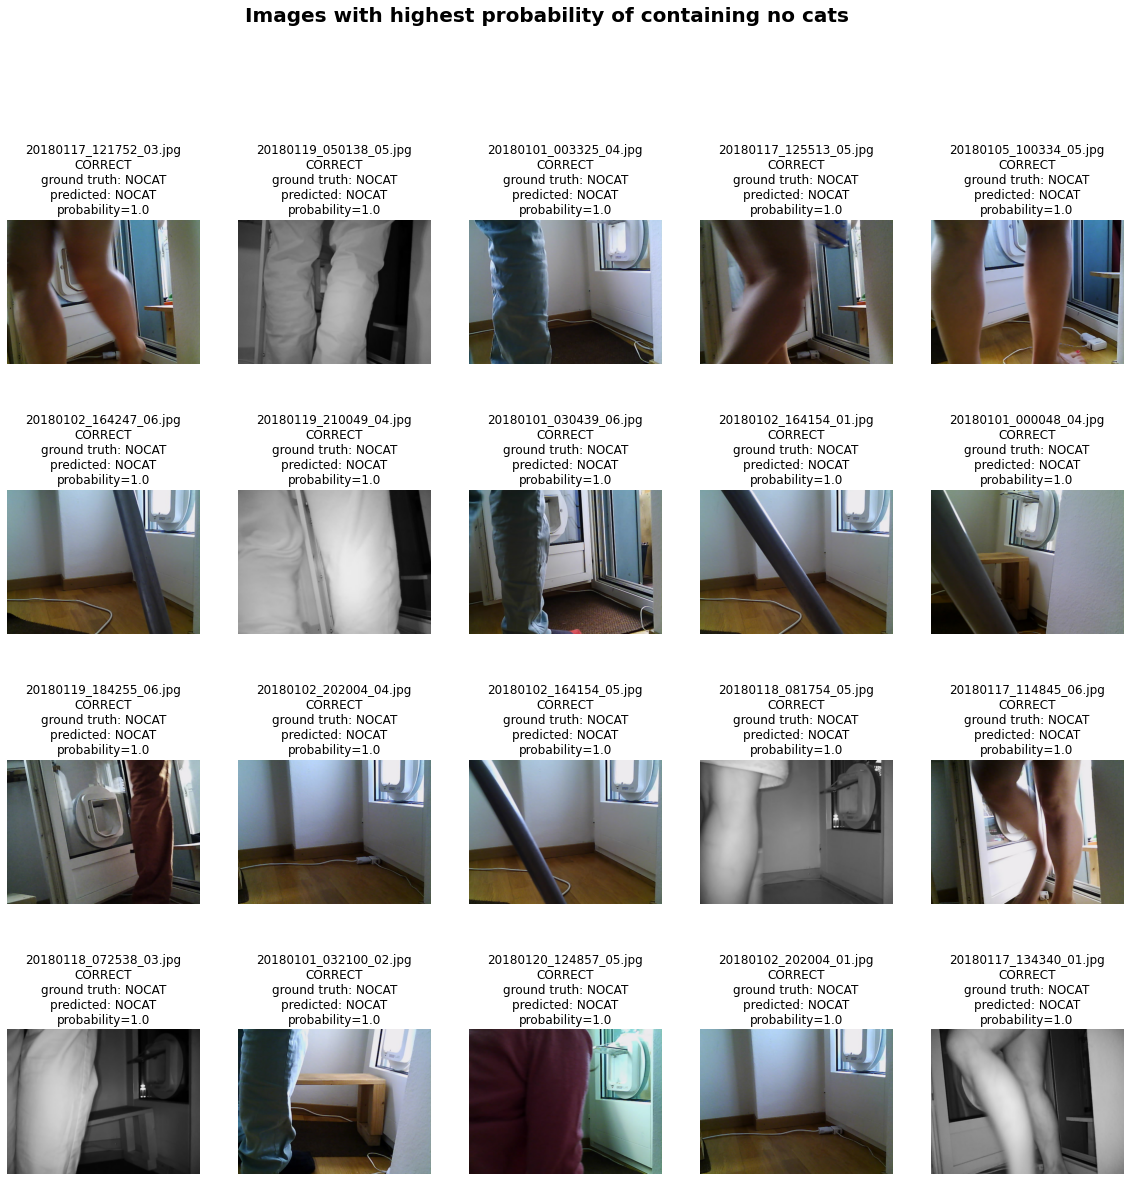

In [102]:
img_list = get_images_with_sorted_probabilities(prediction_table,
                                                             get_highest_probability=True,
                                                             label=1,
                                                             number_of_items=20,
                                                             only_false_predictions=False)
message = 'Images with highest probability of containing no cats'
display(img_list, message)

In [113]:
img_list = get_images_with_sorted_probabilities(prediction_table,
                                                              get_highest_probability=False,
                                                              label=0,
                                                              number_of_items=20,
                                                              only_false_predictions=False)
message = 'Images classified as Cat, with lowest probability'
display(img_list, message)

In [95]:
img_list = get_images_with_sorted_probabilities(prediction_table,
                                                        get_highest_probability=False,
                                                        label=1,
                                                        number_of_items=20,
                                                        only_false_predictions=True)
message = 'Wrongly classified images, with lowest probability'
display(img_list, message)

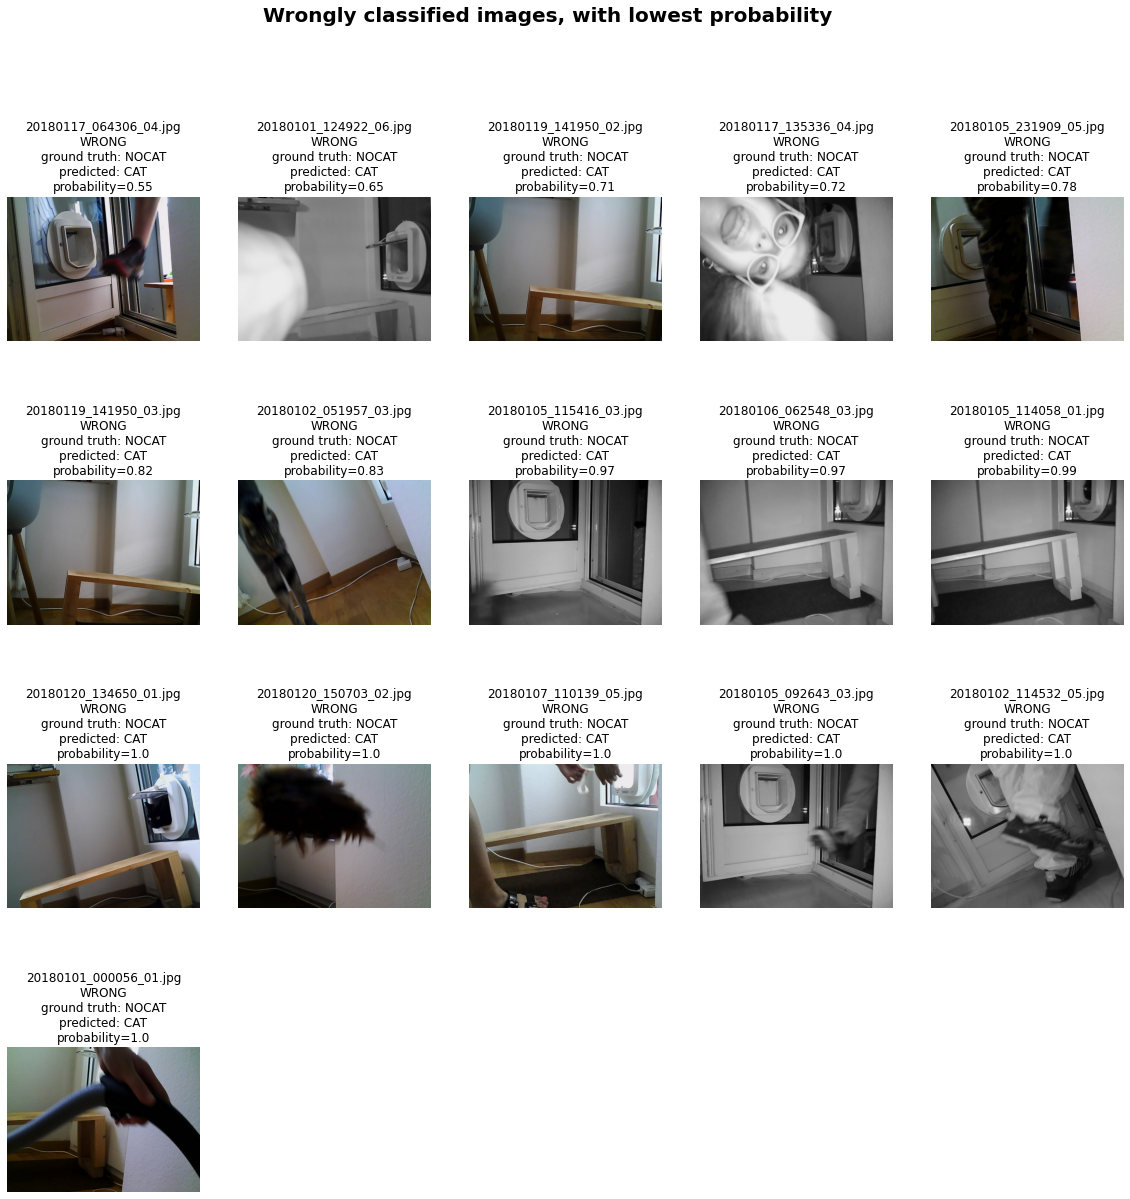

In [96]:
img_list = get_images_with_sorted_probabilities(prediction_table,
                                                        get_highest_probability=False,
                                                        label=0,
                                                        number_of_items=20,
                                                        only_false_predictions=True)
message = 'Wrongly classified images, with lowest probability'
display(img_list, message)
